In [1]:
%matplotlib inline
# Larger CNN for the MNIST Dataset
import numpy
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K

import pickle

from sklearn import svm, datasets
from sklearn.metrics import confusion_matrix

import itertools

import matplotlib.pyplot as plt

# The ordering must be channels_last, so I set image_dim_ordering accordingly
# NHWC or 'last channel' format is expected by X-CUBE-AI
# https://community.st.com/s/question/0D50X0000APZ3t8SQD/invalid-network-and-not-implemented-input-size-smaller-than-filter-kernel-is-not-handled-error-in-log
K.set_image_dim_ordering('tf')

Using TensorFlow backend.


In [2]:
# fix random seed for reproducibility
seed = 7
numpy.random.seed(seed)
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][width][height][pixels]
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255
# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

This time we define a large CNN architecture with additional convolutional, max pooling layers and fully connected layers. The network topology can be summarized as follows.
1. Convolutional layer with 30 feature maps of size 5×5.
2. Pooling layer taking the max over 2*2 patches.
3. Convolutional layer with 15 feature maps of size 3×3.
4. Pooling layer taking the max over 2*2 patches.
5. Dropout layer with a probability of 20%.
6. Flatten layer.
7. Fully connected layer with 128 neurons and rectifier activation.
8. Fully connected layer with 50 neurons and rectifier activation.
9. Output layer.

In [3]:
# define the larger model
def larger_model():
 # create model
 model = Sequential()
 model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=(28, 28, 1)))
 model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
 model.add(MaxPooling2D((2, 2)))
 model.add(Dropout(0.20))
 model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
 model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
 model.add(MaxPooling2D(pool_size=(2, 2)))
 model.add(Dropout(0.25))
 model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
 model.add(Dropout(0.25))
 model.add(Flatten())
 model.add(Dense(128, activation='relu'))
# model.add(BatchNormalization())
 model.add(Dropout(0.25))
 model.add(Dense(num_classes, activation='softmax'))
 model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.RMSprop(),metrics=['accuracy'])

 return model

Like the previous two experiments, the model is fit over 10 epochs with a batch size of 200.

In [4]:
# build the model
model = larger_model()
# Fit the model
h = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=200)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 340s 6ms/step - loss: 0.3039 - acc: 0.9089 - val_loss: 0.0368 - val_acc: 0.9871
Epoch 2/10
60000/60000 [==============================] - 343s 6ms/step - loss: 0.0660 - acc: 0.9801 - val_loss: 0.0266 - val_acc: 0.9914
Epoch 3/10
60000/60000 [==============================] - 341s 6ms/step - loss: 0.0468 - acc: 0.9859 - val_loss: 0.0193 - val_acc: 0.9932
Epoch 4/10
60000/60000 [==============================] - 340s 6ms/step - loss: 0.0412 - acc: 0.9877 - val_loss: 0.0203 - val_acc: 0.9937
Epoch 5/10
60000/60000 [==============================] - 338s 6ms/step - loss: 0.0328 - acc: 0.9904 - val_loss: 0.0192 - val_acc: 0.9938
Epoch 6/10
60000/60000 [==============================] - 337s 6ms/step - loss: 0.0297 - acc: 0.9912 - val_loss: 0.0233 - val_acc: 0.9922
Epoch 7/10
60000/60000 [==============================] - 337s 6ms/step - loss: 0.0277 - acc: 0.9917 - val_loss: 0.0181 - 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


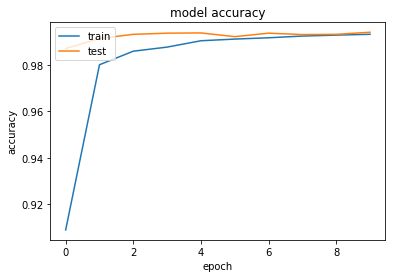

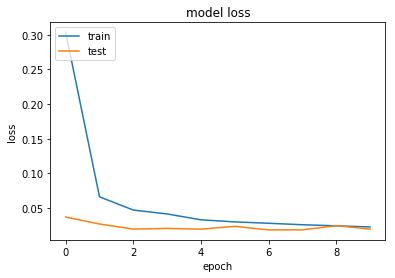

In [5]:
#
axes = plt.gca()

# set x label range
r = numpy.arange(0,10)

# list all data in history
print(h.history.keys())
# summarize history for accuracy
plt.plot(r, h.history['acc'])
plt.plot(r, h.history['val_acc'])
plt.title("model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.xlim(32,224)
plt.show()

# summarize history for loss
plt.plot(r, h.history['loss'])
plt.plot(r, h.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.xlim(32,224)
plt.show()

In [6]:
# save the model
model.save("Mnist_Keras3.h5")
# save corresponding training history
#with open("Mnist_Keras3_history.pkl","wb") as f:
# pickle.dump(h, f)

In [7]:
# Print out model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 24, 24)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 12, 12)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 12, 12)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 12, 12)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 12, 12)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 6, 6)          0         
__________

In [8]:
#
preds = model.predict_classes(X_test)

In [9]:
# Funtion to plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [10]:
#
test_labels = y_test
# https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la
test_labels = numpy.argmax(test_labels, axis=1)
cnf_matrix = confusion_matrix(test_labels, preds)

Confusion matrix, without normalization
[[ 975    1    0    0    0    0    2    1    1    0]
 [   0 1135    0    0    0    0    0    0    0    0]
 [   0    2 1027    1    0    0    0    2    0    0]
 [   0    0    0 1008    0    0    0    1    1    0]
 [   0    0    0    0  981    0    0    0    0    1]
 [   0    0    0    6    0  885    1    0    0    0]
 [   2    3    0    0    3    5  943    0    2    0]
 [   0    3    1    0    0    0    0 1024    0    0]
 [   0    0    1    1    0    1    0    0  969    2]
 [   0    0    0    0    8    3    0    2    2  994]]
Normalized confusion matrix
[[9.95e-01 1.02e-03 0.00e+00 0.00e+00 0.00e+00 0.00e+00 2.04e-03 1.02e-03
  1.02e-03 0.00e+00]
 [0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00]
 [0.00e+00 1.94e-03 9.95e-01 9.69e-04 0.00e+00 0.00e+00 0.00e+00 1.94e-03
  0.00e+00 0.00e+00]
 [0.00e+00 0.00e+00 0.00e+00 9.98e-01 0.00e+00 0.00e+00 0.00e+00 9.90e-04
  9.90e-04 0.00e+00]
 [0.00e+00 0.00e+00 0

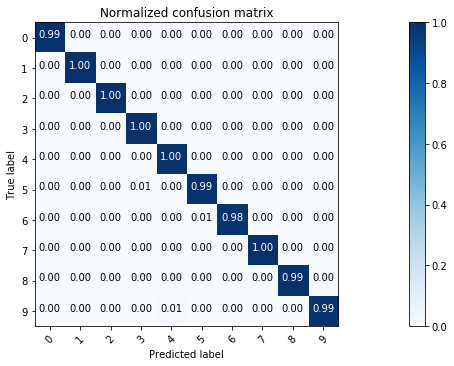

In [11]:
#
class_names = [i for i in range(10)]
numpy.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,5))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure(figsize=(20,5))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='Mnist_Keras3.png', show_shapes=True, show_layer_names=True)

import matplotlib.image as mpimg
img = mpimg.imread('Mnist_Keras3.png')
plt.imshow(img)